In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---------------------

# Retrieving and Preprocess Data

Image size:  100


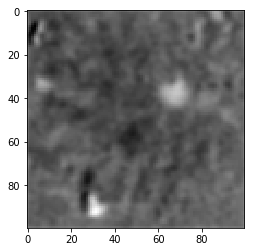

In [2]:
dataset = np.load('/home/kevinteng/Desktop//jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy')
NEW_SIZE = 100
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
# re_list = re_list.astype('float32')
re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

In [3]:
#apply min max norm for mean image
re_list = utils.min_max_norm(re_list)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(re_list))
print('Min value:', np.min(re_list))


Max value: 1.0
Min value: 0.0


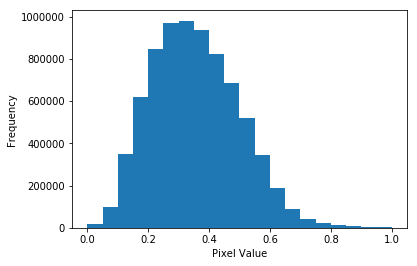

In [4]:
#plot historgram for min max norm image
plt.hist(tf.reshape(re_list, [-1]),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Helper Function

In [5]:
def create_ran_numbers(img_size):
    '''
    Function to create random coordinates 
    
    @param img_size: Image size 
    
    return:
    random generated x,y coordinates 
    '''
    c1=np.random.randint(img_size, size=1)
    c2=np.random.randint(img_size, size=1)
    c1=tf.convert_to_tensor( c1,dtype=None,dtype_hint=None,name=None)
    c2=tf.convert_to_tensor( c2,dtype=None,dtype_hint=None,name=None)
    return c1,c2

@tf.function
def create_tf_tilecords(coord_list, img_size):
    o1,o2=coord_list
    multiply=tf.constant([img_size*img_size])
    y1=tf.reshape(tf.tile(o1,multiply),[img_size,img_size,1])
    y2=tf.reshape(tf.tile(o2,multiply),[img_size,img_size,1])

    y=tf.concat((y1,y2),axis=2)

    return tf.dtypes.cast(y, tf.float32),tf.dtypes.cast(coord_list, tf.float32)

@tf.function
def tf_create_onehotcords(dat):
    o1,o2=dat
    y1=tf.one_hot(o1,100)
    y2=tf.one_hot(o2,100)
    y2=tf.transpose(y2)
    y=tf.math.multiply(y1,y2)
    #y=tf.transpose(y)
    return y

def create_dat_samples(n):
    '''
    Function to create stacks of coordinates, tiled coordinates, one hot images
    @param n: number of neurons
    '''
    ta = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    tb = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    coords = tf.TensorArray(tf.float32, size=0, dynamic_size = True)
    for _ in tf.range(n):
        dat=create_ran_numbers(img_size=100)
        b1,b2=create_tf_tilecords(dat, 100)
        c1=tf_create_onehotcords(dat)
        c1=tf.expand_dims(c1, axis=2, name=None)
        
        #tile coordinates
        ta = ta.write(_, b1/99)  #(n, img_size, img_size, 1)
        #one hot images
        tb = tb.write(_, c1) #(n, img_size, img_size, 1)
        #coordinates
        coords = coords.write(_, dat) #(n, 2, 1)
    return coords.stack(), ta.stack(),tb.stack()

def neuron_like_image(n_neurons):
    '''
    Function to paint neuron-like images
     @param n_neurons: number of neurons
    '''
    _,_,one_hot_imgs = create_dat_samples(n_neurons)
    stack_imgs = tf.reduce_sum(one_hot_imgs, axis = 0)
    return tf.expand_dims(stack_imgs, axis = 0) #(1, img_size, img_size, 1)

def stack4plot(one_hot_imgs):
    '''
    Functions to sum all one hot images along axis=0 for easy plot
    '''
    return tf.squeeze(tf.reduce_sum(one_hot_imgs, axis = 0))

---

# Validation

In [6]:
n_neurons = 40
img_size = 100
coords,_, ori_one_hot_imgs = create_dat_samples(n_neurons)
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[40 1 1 2]


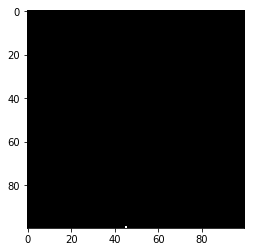

In [7]:
plt.imshow(tf.squeeze(ori_one_hot_imgs[0]), cmap = 'gray')

-----------------------------------

# Model

In [8]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers

def encoder(inps, img_size):
    #1st block
    coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 32, kernel_size = 3, padding='same')(inps)
    leaky01 =tf.keras.layers.LeakyReLU(0.5)(coord01)
    coord02 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 1, kernel_size = 3, padding='same')(leaky01)
    leaky02 = tf.keras.layers.LeakyReLU(0.5)(coord02)
    add01 = tf.keras.layers.Add()([leaky02, inps])
    
    #2nd block
    coord03 =  CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                      filters = 128, kernel_size = 3, padding='same')(add01)
    leaky03 = tf.keras.layers.LeakyReLU(0.5)(coord03)
    coord04 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky03)
    leaky04 = tf.keras.layers.LeakyReLU(0.5)(coord04)
    add02 = tf.keras.layers.Add()([leaky04, add01])
    
    #3rd block
    coord05 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                    filters = 256, kernel_size = 3, padding='same')(add02)
    leaky05 = tf.keras.layers.LeakyReLU(0.5)(coord05)
    coord06 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 1, kernel_size = 3, padding='same')(leaky05)
    leaky06 = tf.keras.layers.LeakyReLU(0.5)(coord06)
    add03 = tf.keras.layers.Add()([leaky06, add02])

    #4th block
    coord07 =CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                       filters = 128, kernel_size = 3, padding='same')(add03)
    leaky07 = tf.keras.layers.LeakyReLU(0.5)(coord07)
    coord08 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky07)
    leaky08 = tf.keras.layers.LeakyReLU(0.5)(coord08)
    add04 =tf.keras.layers.Add()([leaky08, add03])
    
    #5th block
    coord09 =CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                       filters = 64, kernel_size = 3, padding='same')(add04)
    leaky09 = tf.keras.layers.LeakyReLU(0.5)(coord09)
    coord10=CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky09)
    leaky10 = tf.keras.layers.LeakyReLU(0.5)(coord10)
    add05 = tf.keras.layers.Add()([leaky10, add04])
    
    #6th block
    coord11 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                    filters = 32, kernel_size = 3, padding='same')(add05)
    leaky11 = tf.keras.layers.LeakyReLU(0.5)(coord11)
    coord12 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky11)
    leaky12 = tf.keras.layers.LeakyReLU(0.5)(coord12)
    add06 = tf.keras.layers.Add()([leaky12, coord11])
    output = Conv2D(1, kernel_size = 3,activation = 'linear', padding='same')(add06)
    
    return output


def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)

    return output

def latent_space(encoded_imgs, deconv_imgs, coords, batch_size):
    '''
    This function construct the dot product of the output of an encoder(batch_size, img_size, img_size, 1) 
    with the one hot images generated by decoord-conv(n_neurons, img_size, img_size, 1), which yields
    similarity score (batch_size, n_neurons). Similarity score is then concatenate to the last layer of the 
    input coordinates with the corresponding batch (batch_size, n_neurons, 3)
    
    @encoded_imgs: output images from the encoder
    @deconv_imgs: one hot images generated from the coordinate list 
    @coords: A list of coordinates generated randomly based on the number of neurons
    @batch_size: Batch size of the input image for encoder, to allocate size for writing in loop
    
    return: 
        latent space with dim (batch_size, n_neurons, 3, 1)
    '''
    similarity_score = tf.tensordot(encoded_imgs, deconv_imgs, [[1,2,3],[1,2,3]]) #(batch_size, n_neurons)
    squeeze_coords = tf.squeeze(coords/(img_size-1)) #coords dim (n_neurons, 1, 1, 2) = > (n_neurons, 2)
    latent = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(batch_size):
        concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[i]), axis=-1)    
        latent = latent.write(i, concat) #(batch_size, n_neurons, 3)
    return tf.expand_dims(latent.stack(), axis = -1), similarity_score

def decoder(latent_dim, img_size):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_block(dense_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 64, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = coordconv_block(up_02, x_dim = img_size, y_dim = img_size, 
                              filters = 1, kernel_size = 3, strides = 1,
                              padding = 'same', activation = None)
    return output

class learnable_coords(layers.Layer):
    def __init__(self, coords):
        super(learnable_coords, self).__init__()
        self.learned_coords = tf.Variable((coords), trainable = True)

    def __call__(self, img_size):
        y = self.learned_coords/(img_size-1) #normalize the coordinates
    #         y = tf.clip_by_value(y, clip_value_min=0, clip_value_max=1) #clip values
        return y
    
def dataset_parse(dataset_path, NEW_SIZE):
    dataset = np.load(dataset_path)
    #re_list = dataset
    re_list = utils.resize(dataset, NEW_SIZE)
    #Dimension for network should include the color channel 
    re_list = np.expand_dims(re_list, axis = -1)
    #Cast data type to float32 for TensorFlow
    # re_list = re_list.astype('float32')
    re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)
    
    return re_list

def stack4plot(one_hot_imgs):
    '''
    Functions to sum all one hot images along axis=0 for easy plot
    '''
    return tf.squeeze(tf.reduce_sum(one_hot_imgs, axis = 0))

In [9]:
# def encoder02(inps, img_size):
#     #1st block
#     coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
#                         filters = 256, kernel_size = 3, padding='same')(inps)
#     leaky01 =tf.keras.layers.LeakyReLU(0.5)(coord01)
#     conv01 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", activation = 'relu')(leaky01 )
#     leaky02 = tf.keras.layers.LeakyReLU(0.5)(conv01)
#     output = Conv2D(1, kernel_size = 3,activation = 'linear', padding='same')(leaky02 )
#     return output

-----------------------------------------------------------------

## Build Model

In [10]:
#build encoder 
inps = Input(shape=(img_size, img_size, 1))
encoder_model = Model(inps, encoder(inps, img_size))

#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim, img_size))

#learnable coords
l_coords = learnable_coords(coords)

In [11]:
# encoder_model.summary()

## Train Model

--------------------------------------

In [12]:
lr=0.001
opt = tf.keras.optimizers.Adam(lr)
loss_fn = tf.losses.MeanSquaredError()

@tf.function
def train_fn(inp_imgs, coords, img_size, batch_size):
    with tf.GradientTape() as tape:
        #custom layer for updating coordinates
        updated_coords = l_coords(img_size)
        m1 = tf.constant([1,img_size,img_size,1], tf.int32) #multiplier for tiling 
        #tile coordinates
        tile_cd = tf.tile(updated_coords, m1)
        #de-coordconv model
        de_coordconv.trainable = False #freeze de-coordconv
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd),[-1,img_size, img_size, 1]) #(n_neurons, img_size, img_size, 1)
        #output from encoder 
        encoder_output = encoder_model(inp_imgs)
        #latent space
        latent, similarity_score = latent_space(encoder_output, one_hot_imgs, coords, batch_size)#(batch_size, n_neurons, 3, 1)
        #reconstruction 
        reconstruction = decoder_model(latent)
        loss = loss_fn(inp_imgs, reconstruction)
        
    varis = encoder_model.trainable_variables + decoder_model.trainable_variables + l_coords.trainable_variables
    grad_model = tape.gradient(loss, varis)
#     grad_coords = tape.gradient(loss, l_coords.trainable_variables)
    opt.apply_gradients(zip(grad_model, varis))
#     opt.apply_gradients(zip(grad_coords, l_coords.trainable_variables))
    
    return loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad_model 

In [13]:
# ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'

# for d in sorted(os.listdir(ds_dir)):
#     merge_d = os.path.join(ds_dir+d)
#     imgs = dataset_parse(merge_d, 100)
#     break

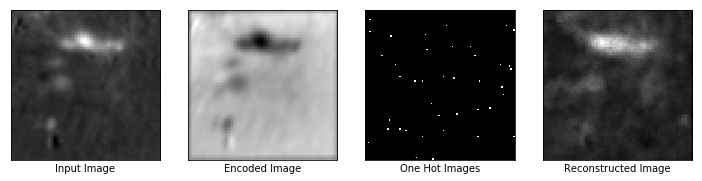

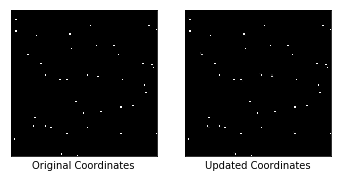

Epochs: 10, Loss: 0.0030818581581115723
Similarity scores: [ 0.44967383  1.5991731   2.0872452   1.1971873   1.1233633  -1.7911831
 -0.93132913  0.9084911   1.63819     0.02104446  1.1679255  -1.0945507
  0.5688775   1.6821586   1.8119255   0.9767248   0.9531671   1.1819794
  0.63337874  2.238496    1.2479675  -0.42813924  0.6807237   0.28409433
  1.8315945   1.4257503   2.8969746  -1.4728329   2.3865573   2.1224263
 -0.19594774  1.5626333   0.24881919  0.10353025  1.0931667   1.8200111
  1.3828747   2.0320745   0.99967796  1.489522  ]
Updated Coordinates: [[[0.4545993 0.9999572]]]
Gradient min:-0.0030678955372422934, max:0.004725408740341663



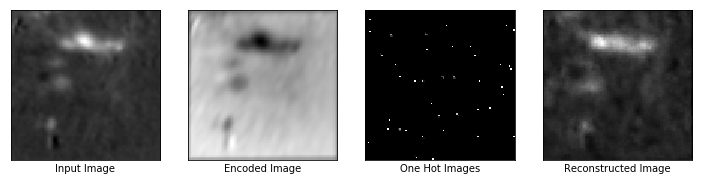

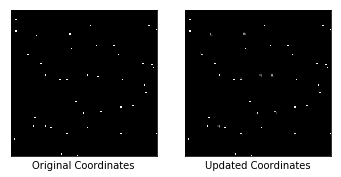

Epochs: 20, Loss: 0.0022720154374837875
Similarity scores: [ 1.4376287   2.355372    2.641297    2.472242    2.4827294  -2.4432542
 -1.4176211   2.9874873   1.9638999   1.7669041   4.023794   -0.9575026
  0.9864137   1.6552997   3.2009594   2.9807155   0.67119944  2.3519888
  0.91209865  1.6827985   2.287015   -0.19857527  2.1409914   0.9203627
  1.9229214   1.998558    3.2335773  -2.136061    1.6840963   1.850461
 -0.60086745  1.9747853   0.28970385  1.2370925   1.791958    2.8770266
  3.182559    1.0535313   1.1691262   1.6663095 ]
Updated Coordinates: [[[0.4545988 0.9997534]]]
Gradient min:-0.0021883987355977297, max:0.0034827697090804577



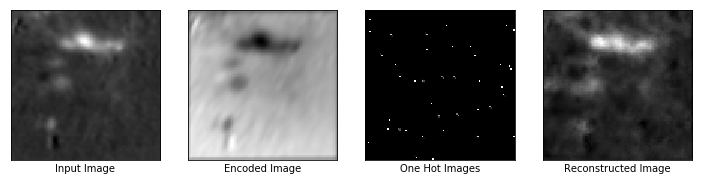

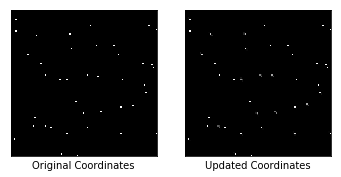

Epochs: 30, Loss: 0.0017262668116018176
Similarity scores: [ 1.9350497   2.569779    3.2088933   3.0223234   2.952786   -2.6603866
 -1.4820088   3.6468012   2.0245726   2.2372632   5.074635   -0.8779733
  1.2504178   1.5899472   3.7429388   3.450168    0.742618    2.8435354
  1.0767689   1.6392623   2.7332067   0.03812008  2.7017682   1.0939991
  1.832559    2.4518044   3.9208283  -2.3624036   1.4809809   2.104216
 -0.76846415  2.0764463   0.14952108  1.6573534   2.0677793   3.426368
  3.7822938   0.8031785   1.2625204   1.5864375 ]
Updated Coordinates: [[[0.45461708 0.99923736]]]
Gradient min:-0.0009573274292051792, max:0.001523311366327107



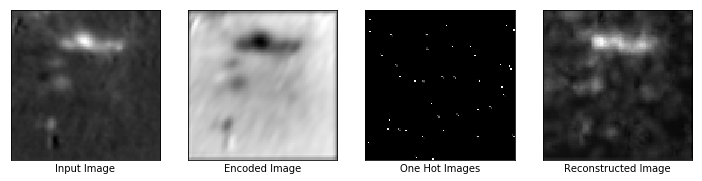

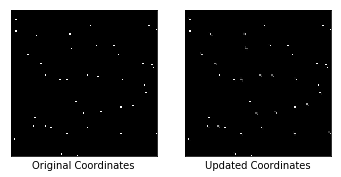

Epochs: 40, Loss: 0.002853456884622574
Similarity scores: [ 2.2665367   3.9133205   3.815274    2.993409    2.943477   -1.1933634
 -0.5371986   3.069863    4.297163    1.8392514   4.007501   -0.12138963
  2.1475623   4.5148063   4.1304555   2.7773633   2.6493297   2.9404578
  2.272008    3.9920604   3.1075106   0.94687295  2.5675645   1.4377066
  4.698427    2.8484485   4.753549   -0.85997516  5.2433467   3.538044
  0.5852903   4.1024756   1.1978468   1.6130424   3.013542    3.5980873
  3.3963737   2.6925719   3.1024573   3.954939  ]
Updated Coordinates: [[[0.4550471 0.9981192]]]
Gradient min:-0.003129761666059494, max:0.0029926691204309464



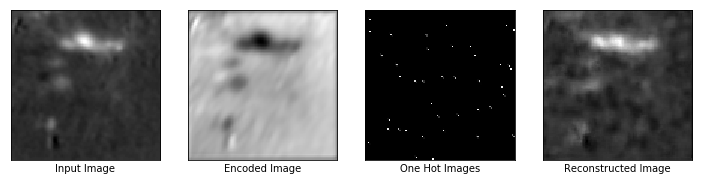

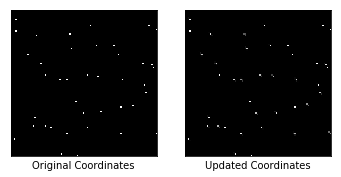

Epochs: 50, Loss: 0.0016657422529533505
Similarity scores: [ 1.3778465   3.7040803   3.9928913   2.8992898   2.4075983  -1.89629
 -0.75115436  2.0135322   4.1608796   0.73791003  2.6548483  -1.1194791
  2.2107527   4.530327    3.686109    1.5315433   2.644321    2.982974
  2.1506708   4.416385    2.8189366   0.15751864  1.937579    1.8916234
  4.820508    2.8495972   5.0111785  -1.3515368   5.3859196   3.6500897
  0.01262435  3.8974533   1.3877032   0.23209396  2.692824    4.2197165
  2.5360856   1.6161933   2.9997094   4.0680017 ]
Updated Coordinates: [[[0.45495054 0.99847114]]]
Gradient min:-0.0016134737525135279, max:0.0018305541016161442



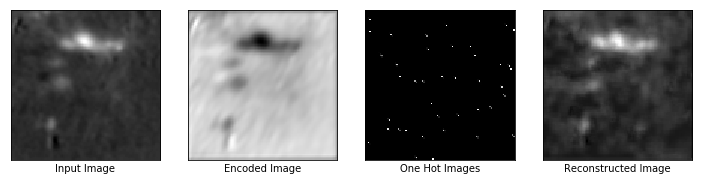

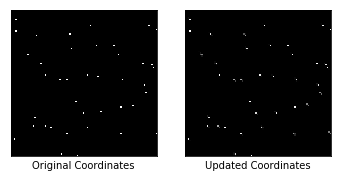

Epochs: 60, Loss: 0.0022129847202450037
Similarity scores: [ 2.2565153   3.6429763   4.076596    3.3314617   3.094676   -3.0784316
 -1.3716409   3.4602973   3.6474965   1.6886579   4.6723337  -1.2487916
  1.9509515   3.596793    4.1830797   2.8477201   1.8833894   3.3867612
  1.7142192   3.4459522   3.1605053   0.01639568  3.161245    2.1187348
  3.8585713   2.8527381   4.8508883  -2.2181413   3.7412775   3.0540507
 -0.94517285  3.5016015   0.83328736  0.8704536   2.7737908   4.5114145
  3.8130827   1.0913562   2.5297127   3.1697    ]
Updated Coordinates: [[[0.4549793 0.9985155]]]
Gradient min:-0.004107111599296331, max:0.003777936566621065



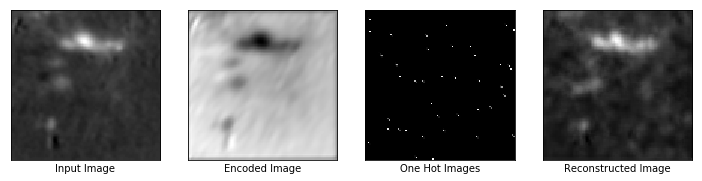

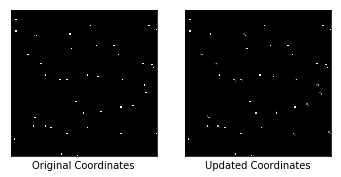

Epochs: 70, Loss: 0.0016810320084914565
Similarity scores: [ 2.644153   3.9430788  5.2561493  3.9643958  3.7918985 -3.5770402
 -1.5569202  5.0435886  3.586695   2.8144538  6.941613  -0.9456466
  2.0732644  3.2372384  4.8707542  4.59579    1.5375667  4.037175
  1.6764793  2.936847   3.6397429  0.4767881  4.059659   2.0256057
  3.3993185  3.728183   5.850326  -2.7365634  2.8742945  3.647019
 -1.58201    3.6086001  0.518516   1.8539475  3.0813725  5.2247024
  4.853871   1.5241568  2.4978974  2.5948863]
Updated Coordinates: [[[0.4551332  0.99817544]]]
Gradient min:-0.00279670930467546, max:0.002571348799392581



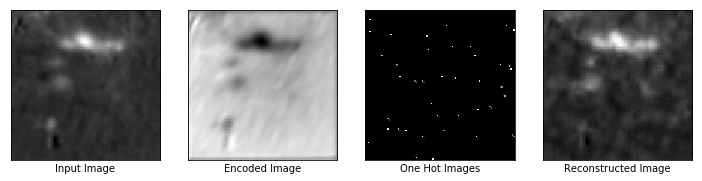

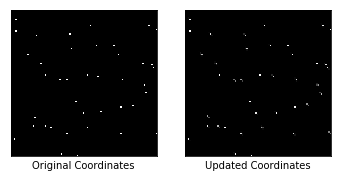

Epochs: 80, Loss: 0.0017363257938995957
Similarity scores: [ 2.6479564   4.1357255   5.05403     3.9933074   3.856258   -2.8733323
 -0.910485    4.943672    3.8059711   3.024822    6.159579   -0.59918207
  2.2879167   3.402466    4.8624682   4.3069205   1.7454727   4.005755
  1.9706297   2.9185972   3.70708     0.9954557   3.692389    2.3080583
  3.7018547   3.8072815   5.507519   -2.2116725   3.0149932   3.6842403
 -1.2485985   3.8666868   0.7594747   1.924935    3.2899802   5.074857
  4.7645626   1.2128035   2.7589548   2.9634335 ]
Updated Coordinates: [[[0.45536017 0.9975446 ]]]
Gradient min:-0.0007718699052929878, max:0.0010475122835487127



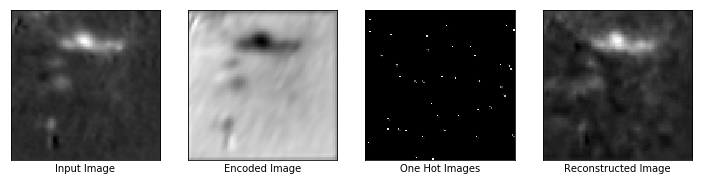

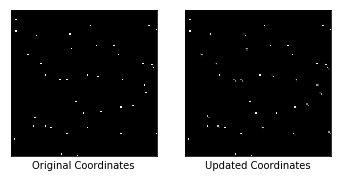

Epochs: 90, Loss: 0.0012429736088961363
Similarity scores: [ 2.8086903   4.0906315   5.93413     3.8340254   3.7236931  -3.6494339
 -1.3576896   4.735612    3.8600187   2.5039465   5.6132703  -0.73560673
  2.4092193   3.5357587   4.6312404   3.7305615   1.6176977   4.0195003
  2.0085194   3.8521426   3.671118    0.9601868   3.8379295   2.3154817
  3.9108672   4.2657757   6.6738925  -2.8463714   3.3804321   4.487226
 -0.9333847   3.7884212   0.8916306   1.1906868   3.1585474   5.5906277
  4.3912997   1.6408488   2.7420297   2.8469055 ]
Updated Coordinates: [[[0.4553912 0.997529 ]]]
Gradient min:-0.0017656157724559307, max:0.0014104584697633982



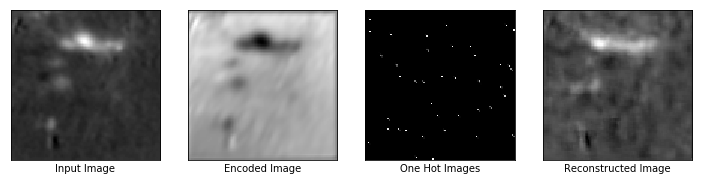

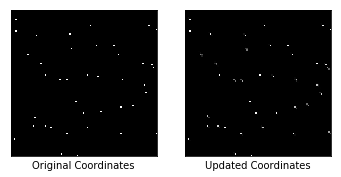

Epochs: 100, Loss: 0.003124294336885214
Similarity scores: [ 1.0439848   3.61204     5.3221893   2.6629684   2.151825   -1.6261659
  0.4708852   2.1601088   4.2889185   0.74325216  2.081139   -0.488019
  2.6148503   4.7904067   3.1529636   1.3920585   2.9654272   3.0552726
  2.4332104   5.5280914   2.6794512   1.1037406   1.5990117   1.6986456
  5.1522875   3.9270856   6.536358   -0.66981083  5.866216    5.1655207
  0.56678575  4.001064    2.0102732  -0.17379095  2.6145782   4.6505637
  1.9292815   3.7892284   3.233743    3.3815863 ]
Updated Coordinates: [[[0.45517352 0.997819  ]]]
Gradient min:-0.002406707964837551, max:0.003747182432562113



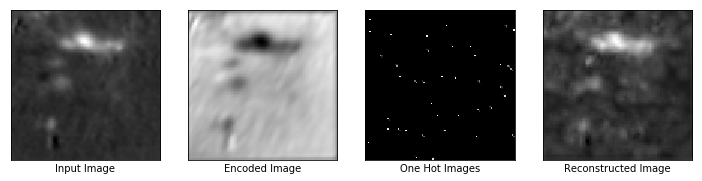

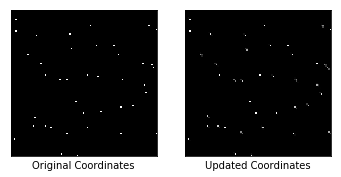

Epochs: 110, Loss: 0.003578202798962593
Similarity scores: [ 2.4823465   5.7816887   6.5404778   4.294467    3.722142   -2.8735242
 -0.4799583   4.052416    6.3949437   1.2631598   3.7860672  -1.2272489
  3.2516222   6.6575747   5.4633884   2.2048924   3.5413992   4.7325163
  3.038725    6.787356    4.3758073   1.0864521   3.104034    3.0011704
  7.2175717   4.6086836   7.5545535  -1.8619854   7.394695    5.366798
 -0.19400547  6.102117    1.7753867  -0.13820915  4.148075    6.4413652
  3.8364964   2.4313056   4.555041    4.953986  ]
Updated Coordinates: [[[0.45629236 0.99708533]]]
Gradient min:-0.005752288270741701, max:0.003456480335444212



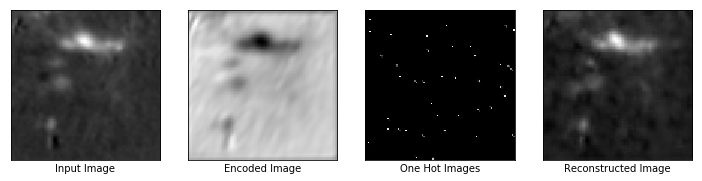

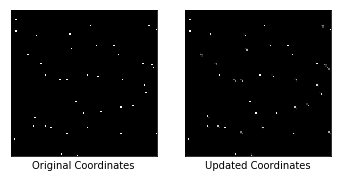

Epochs: 120, Loss: 0.0010842359624803066
Similarity scores: [ 2.6939468   4.3588786   5.6449428   3.886849    3.4044375  -4.1374893
 -1.2206587   4.520826    4.3184013   1.8770262   5.0145607  -1.388584
  2.3743572   4.136016    4.6666436   2.9714406   1.7298313   4.1816955
  1.9235861   4.4268947   3.6949847   0.6635811   3.5315366   2.6030943
  4.7730317   3.890191    6.4043384  -2.899338    4.0476084   4.157061
 -1.4145105   4.1678214   1.2496636   0.29523906  3.1290395   5.7466755
  3.99554     1.3446549   2.9554956   3.0358949 ]
Updated Coordinates: [[[0.45658377 0.99690956]]]
Gradient min:-0.0016285097226500511, max:0.0010372885735705495



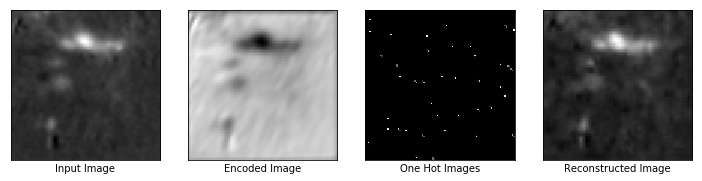

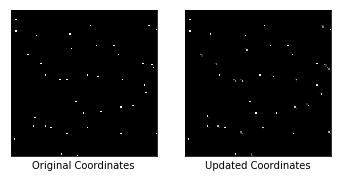

Epochs: 130, Loss: 0.0009361387928947806
Similarity scores: [ 3.081645    4.4303536   6.0793276   3.9987068   3.486555   -4.046568
 -0.9649301   4.7126575   4.365205    1.9622912   5.2106595  -1.2827832
  2.448322    4.189087    4.839094    3.0839622   1.6774163   4.360536
  1.9354483   4.584009    3.831116    0.7239268   3.5612612   2.9041207
  4.7672024   4.1265507   6.908054   -2.9371188   4.055493    4.4946623
 -1.079467    4.1878176   1.5088362   0.14642781  3.2575815   6.0300875
  4.0508113   1.1071993   2.9733734   3.1121893 ]
Updated Coordinates: [[[0.45715848 0.9964806 ]]]
Gradient min:-0.0005873811896890402, max:0.0003482061147224158



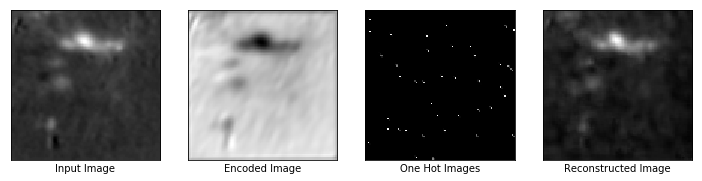

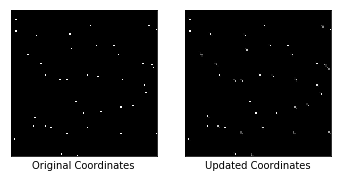

Epochs: 140, Loss: 0.0013359542936086655
Similarity scores: [ 3.5114126  4.5870852  5.33851    4.145977   3.7744799 -4.2752132
 -1.2650924  4.798467   4.228102   2.523734   5.7505207 -1.1667055
  2.3709564  3.7040775  4.994658   3.6061695  1.5029951  4.3226457
  1.8837388  3.93287    3.995876   0.9017332  4.1858077  3.2093234
  4.39158    3.620149   5.678702  -3.0318034  3.3348904  3.774443
 -1.2408556  4.1828775  1.4444324  0.7464282  3.4091444  5.5516253
  4.408177   0.9136059  2.891069   2.856184 ]
Updated Coordinates: [[[0.45712093 0.9967238 ]]]
Gradient min:-0.0010594023624435067, max:0.0010854785796254873



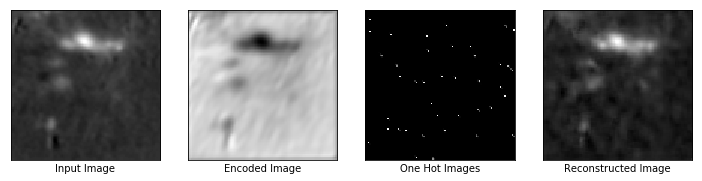

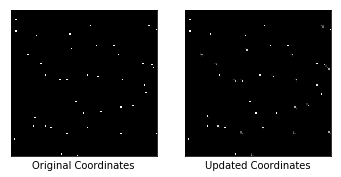

Epochs: 150, Loss: 0.0009913266403600574
Similarity scores: [ 3.115074    4.945879    6.074771    4.3229685   3.818347   -4.155836
 -0.94425297  5.0279903   4.640012    2.4473517   5.6605034  -1.2335238
  2.582464    4.2091165   5.154119    3.5304444   1.8573856   4.5792437
  2.0357676   4.638305    4.127479    1.0158262   3.884122    3.0386121
  5.1054597   4.045776    6.5525556  -3.1297646   4.07059     4.426956
 -1.4861442   4.5524645   1.5167832   0.4073192   3.5358183   6.0634165
  4.529288    1.4108671   3.2013886   3.0125444 ]
Updated Coordinates: [[[0.45710567 0.9967994 ]]]
Gradient min:-0.0006265403935685754, max:0.000602048821747303



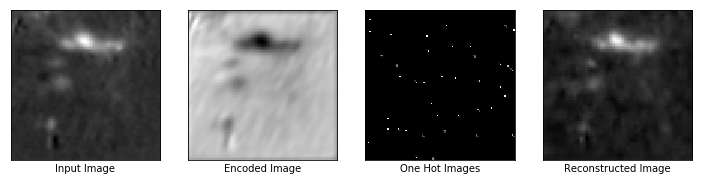

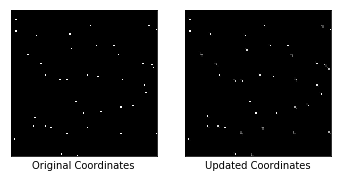

Epochs: 160, Loss: 0.0030590740498155355
Similarity scores: [ 2.6267433   4.667652    6.5289946   4.0608096   3.4075942  -4.262051
 -0.43254924  4.7097206   4.5160522   2.2665887   5.248142   -1.3223733
  2.6846945   4.353225    4.584118    3.3013983   2.1586547   4.4074125
  2.1270933   5.159038    3.7801723   1.0020415   3.4103227   2.7153428
  5.211379    4.3986206   7.598231   -3.0755627   4.467985    5.3106475
 -1.214988    4.2934275   1.7140591   0.14707619  3.2181673   6.2055144
  4.08711     2.30754     3.1627064   3.0834062 ]
Updated Coordinates: [[[0.4572262 0.9967811]]]
Gradient min:-0.006365477107465267, max:0.00264108763076365



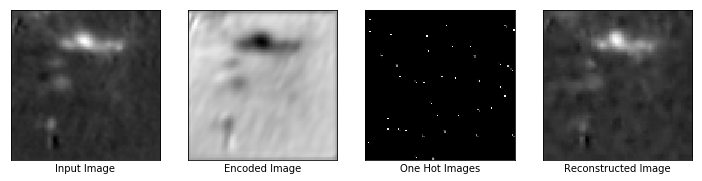

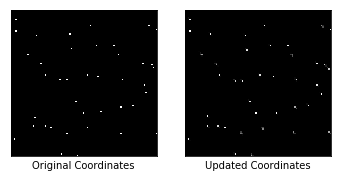

Epochs: 170, Loss: 0.0010226735612377524
Similarity scores: [ 2.391846    4.8807645   6.3835063   3.9325783   3.235613   -4.1982107
 -0.6822173   4.2859087   4.9006763   1.9962668   4.2807713  -1.3021394
  2.723093    4.8590455   4.6740737   2.7845871   2.367632    4.3121223
  2.2660477   5.4686227   3.8085806   0.9449574   3.042186    3.0610015
  5.72867     4.2987337   7.2262416  -2.8869846   5.2196455   5.1177387
 -1.1045257   4.6457176   1.8506334  -0.30348518  3.3932161   6.0799365
  3.807744    2.3697543   3.4056547   3.5924363 ]
Updated Coordinates: [[[0.45712802 0.9969286 ]]]
Gradient min:-0.0009073348483070731, max:0.0004040903877466917



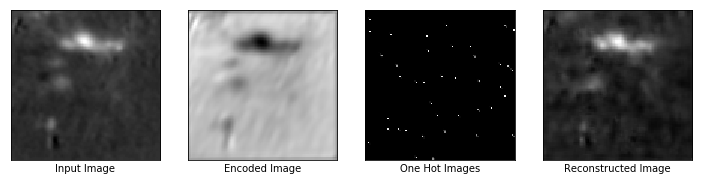

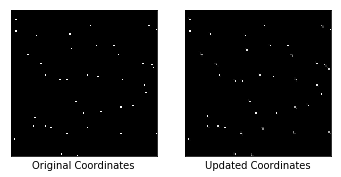

Epochs: 180, Loss: 0.0022701609414070845
Similarity scores: [ 2.892138    5.283839    6.606425    4.169895    3.4657476  -3.6592598
 -0.4879871   4.54859     5.4116983   2.1283317   4.726737   -0.9354581
  3.0562527   5.321184    4.9135456   3.1479995   2.887656    4.5982037
  2.6501565   6.040708    4.102198    1.3047495   3.3956523   3.1575
  6.2535067   4.467608    7.8078346  -2.5043538   5.8240867   5.7000566
 -0.725312    5.160002    2.014742    0.13945322  3.729215    6.2031174
  4.0314765   3.1495516   3.8856068   3.5556548 ]
Updated Coordinates: [[[0.4572329 0.9969103]]]
Gradient min:-0.0032379592303186655, max:0.0013050817651674151



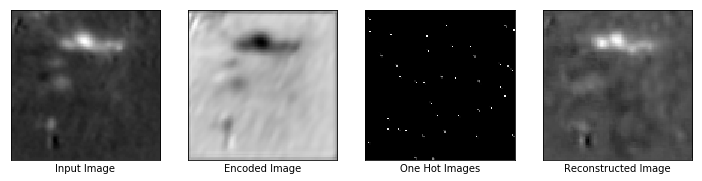

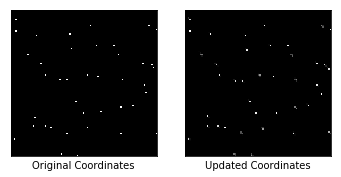

Epochs: 190, Loss: 0.0033928421325981617
Similarity scores: [ 2.5167527   4.016346    4.536865    3.324373    2.8121464  -2.1286778
 -0.12189142  3.5743465   4.0573144   2.107259    4.2332363  -0.3186117
  2.3305452   3.9154034   3.90129     2.9611158   2.1951966   3.5452895
  2.0924678   4.0966735   3.2429936   1.1595038   2.8423605   2.5434065
  4.325921    3.0799212   5.4633937  -1.6027385   4.093393    4.0418777
 -0.23016529  3.928518    0.8815641   0.8019069   2.9298434   4.3508534
  3.285491    2.0563858   2.987127    2.4536676 ]
Updated Coordinates: [[[0.45726502 0.9968628 ]]]
Gradient min:-0.0009094307897612453, max:0.003168945899233222



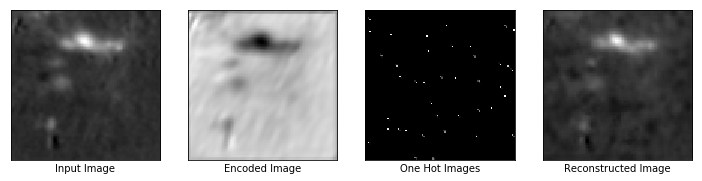

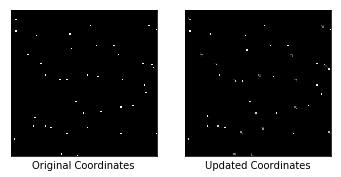

Epochs: 200, Loss: 0.00092880375450477
Similarity scores: [ 3.2109869   4.661566    5.754636    3.8918982   3.1587408  -4.3603015
 -1.0577134   4.3559937   4.7568965   2.1670597   4.6694536  -1.1664686
  2.5209732   4.5275817   4.5647955   3.08935     2.2297254   4.2556233
  2.1799297   4.724013    3.7926376   0.9854853   3.5401576   3.1653984
  5.227376    3.6828685   6.085752   -2.9539099   4.630242    4.2427564
 -1.479352    4.500159    1.4585253   0.03032786  3.2620842   5.453869
  3.71844     1.5775967   3.2927034   3.1903038 ]
Updated Coordinates: [[[0.45742533 0.99684113]]]
Gradient min:-0.0005071205087006092, max:0.0014215552946552634



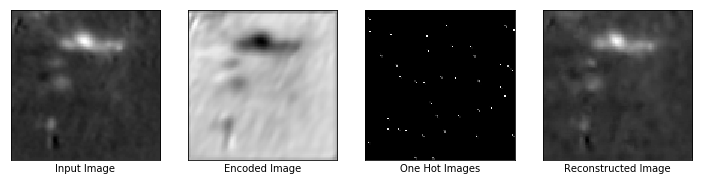

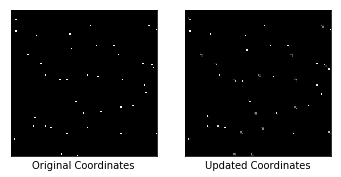

Epochs: 210, Loss: 0.0006898596766404808
Similarity scores: [ 2.9687772   4.992306    5.931615    4.000446    3.0864642  -4.559584
 -1.1887314   4.3346715   5.1237135   1.8826325   4.3419123  -1.562636
  2.5948315   4.9027553   4.7866306   2.695647    2.3845854   4.4837766
  2.1689076   5.171278    3.9019194   0.76947844  3.3193219   3.4540524
  5.6987967   3.6167362   6.197618   -3.1402302   5.062685    4.2737556
 -1.6983428   4.8069315   1.6554561  -0.42446652  3.374938    5.9558096
  3.6497767   1.1508996   3.4893925   3.5667505 ]
Updated Coordinates: [[[0.45785904 0.99648494]]]
Gradient min:-0.00020184968889225274, max:0.00028163669048808515



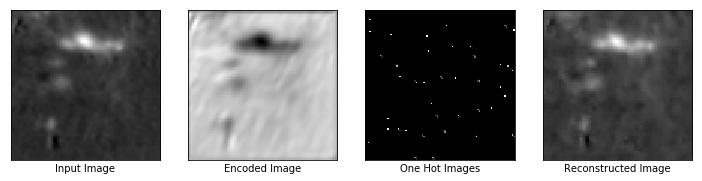

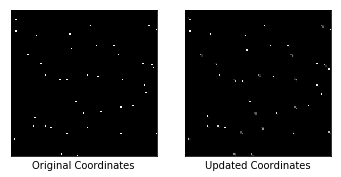

Epochs: 220, Loss: 0.0007505642715841532
Similarity scores: [ 2.7756357  4.7472587  5.971759   3.9175756  2.9472277 -4.471096
 -1.0688678  4.3694487  4.7965813  1.9198599  4.3837395 -1.5038159
  2.5811965  4.5732403  4.555173   2.7135623  2.1879857  4.4011188
  2.1176956  5.115622   3.747887   0.798183   3.144493   3.2724695
  5.404104   3.6694536  6.335817  -3.1258385  4.742502   4.404566
 -1.3086841  4.4976797  1.6594598 -0.4912505  3.173079   6.05008
  3.5667803  1.2943903  3.279998   3.5184042]
Updated Coordinates: [[[0.4580728  0.99638844]]]
Gradient min:-0.0005586916231550276, max:0.00021391398331616074



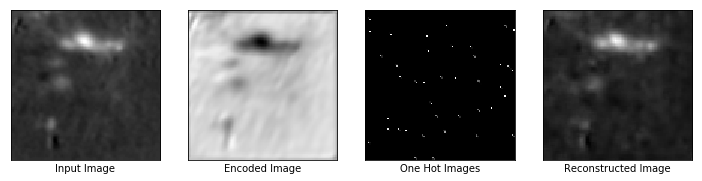

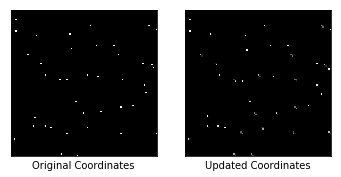

Epochs: 230, Loss: 0.0010747320484369993
Similarity scores: [ 3.8815656   4.92991     5.7164526   4.1445026   3.4997823  -4.1549716
 -0.83804166  4.613957    4.8331814   2.63715     4.7951126  -0.88328576
  2.7531662   4.6001167   4.841952    3.5331268   2.4548738   4.5238976
  2.4038339   4.8815417   3.993401    1.1879598   4.263488    3.5472376
  5.1231055   3.758001    5.6949115  -2.9094532   4.6177564   4.1666346
 -1.0741045   4.6940894   1.4967672   0.3873029   3.561936    5.6717606
  4.042409    1.3008716   3.49024     3.318862  ]
Updated Coordinates: [[[0.45825547 0.996536  ]]]
Gradient min:-0.001357487984932959, max:0.0006220943760126829



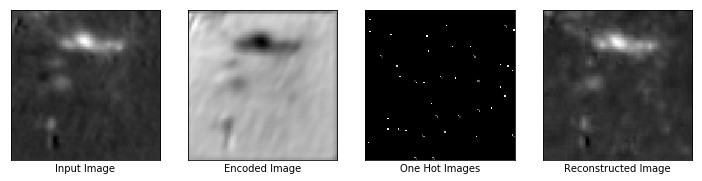

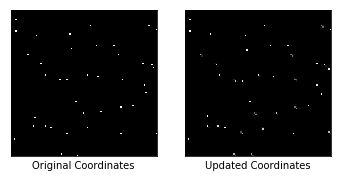

Epochs: 240, Loss: 0.001165055320598185
Similarity scores: [ 3.4021955   5.11459     7.3275867   4.443621    3.4425979  -3.264558
 -0.08973712  5.073959    5.3413706   2.7165086   5.6777997  -0.34804207
  3.2853816   5.3508673   4.8113546   3.8674042   3.0784996   5.08085
  2.942147    6.2925363   4.2180696   1.6360248   3.9331183   3.005948
  6.056364    4.9805164   9.044586   -2.4093654   5.723673    6.640334
 -0.2633771   4.971741    2.062893    0.35530448  3.6786673   6.8078756
  4.160974    4.0592756   3.9926684   3.86438   ]
Updated Coordinates: [[[0.45839903 0.99660444]]]
Gradient min:-0.0010795649141073227, max:3.157614264637232e-05



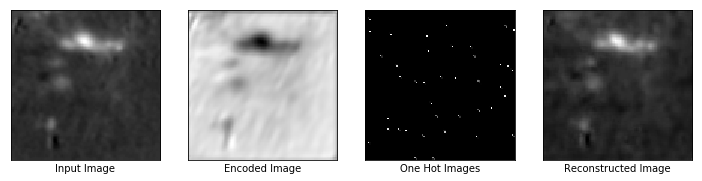

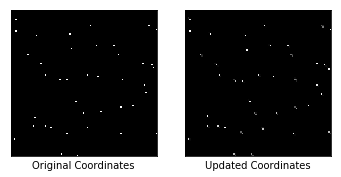

Epochs: 250, Loss: 0.001080511836335063
Similarity scores: [ 3.9010112   5.0070286   5.3563657   4.174407    3.4869921  -3.9058666
 -1.0041982   4.530369    4.8214245   2.519524    4.8288417  -0.87004745
  2.5561464   4.395864    4.971097    3.3303447   2.1412225   4.444666
  2.3580422   4.4385033   4.001745    1.1740146   4.231962    3.5867617
  5.3275914   3.5680854   5.2787986  -2.7390528   4.279652    3.7728577
 -1.2858605   4.7512083   1.875479    0.23135906  3.559066    5.3556604
  4.054254    1.0603163   3.4036553   3.654239  ]
Updated Coordinates: [[[0.45849714 0.9966318 ]]]
Gradient min:-0.00026331504341214895, max:0.0019273307407274842



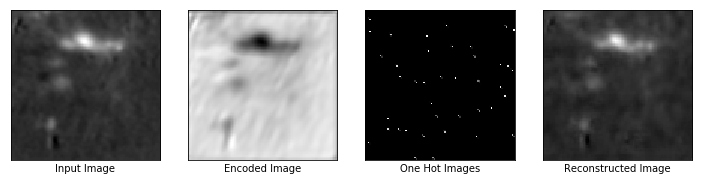

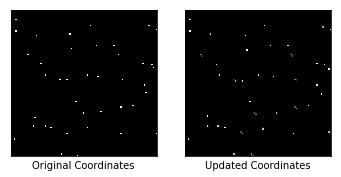

Epochs: 260, Loss: 0.0010050113778561354
Similarity scores: [ 3.7704139   4.9457717   5.1282635   4.119596    3.4254005  -3.8456607
 -1.0425224   4.4638066   4.7595077   2.3877978   4.773046   -0.9126273
  2.4986095   4.3775306   4.890912    3.1299102   2.113869    4.387108
  2.2714942   4.259852    3.9552906   1.159263    4.0517626   3.4542506
  5.1424255   3.3207834   5.171786   -2.7565787   4.089793    3.5649133
 -1.4021809   4.670346    1.7566565   0.1666668   3.517046    5.274863
  3.9752977   0.92196405  3.3723955   3.5908601 ]
Updated Coordinates: [[[0.45863453 0.9965889 ]]]
Gradient min:-0.0001034060915117152, max:0.0014079909306019545



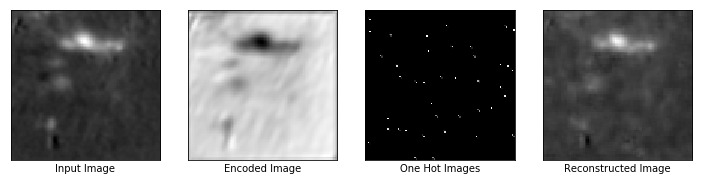

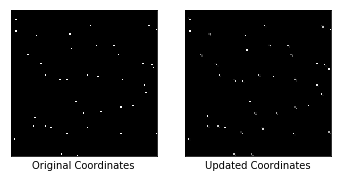

Epochs: 270, Loss: 0.001159685431048274
Similarity scores: [ 4.64803    6.3433475  5.8422728  4.804143   4.0681615 -3.8984911
 -0.8498625  4.5676684  6.407065   2.3489478  5.2175355 -0.827151
  3.2105923  5.9809003  6.043251   3.465082   3.2864678  5.229431
  3.1566803  5.554774   4.889377   1.3496016  4.7674227  4.0213056
  6.9860396  3.7495887  5.462444  -2.5945356  5.9952154  4.142362
 -1.3224012  6.249357   2.1392863  0.410649   4.610165   5.8665924
  4.511052   1.3692226  4.587949   4.4710455]
Updated Coordinates: [[[0.45879373 0.9967327 ]]]
Gradient min:-3.706739153130911e-05, max:0.0009144491632468998



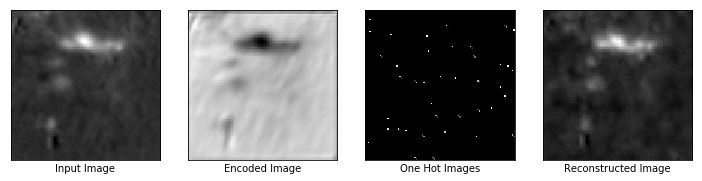

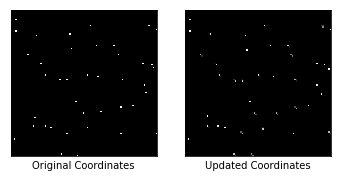

Epochs: 280, Loss: 0.0011137807741761208
Similarity scores: [ 4.09858     5.0801163   6.505397    4.431637    3.593056   -4.0253778
 -0.43447652  5.096587    5.0506754   3.0562882   5.6798496  -0.71372193
  2.9141119   4.698799    4.953004    4.0364976   2.6752992   4.960873
  2.6013956   5.291386    4.1746      1.3774068   4.6229615   3.6916645
  5.685288    4.3714833   6.8859277  -2.9917889   4.7932844   5.064252
 -0.6820284   4.776584    1.9976678   0.39485788  3.642301    6.1444435
  4.351191    2.0886297   3.65777     4.0742416 ]
Updated Coordinates: [[[0.45936745 0.99698174]]]
Gradient min:-0.0014121017884463072, max:0.00018835286027751863



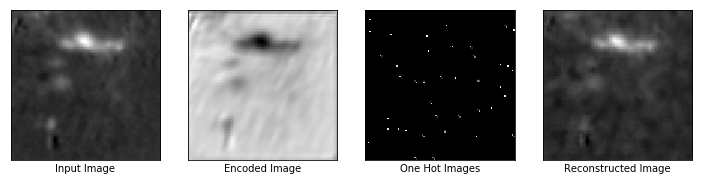

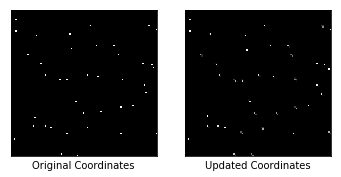

Epochs: 290, Loss: 0.001336907153017819
Similarity scores: [ 3.9462786   4.9610105   5.833597    4.2016296   3.4394782  -4.4526553
 -0.49837106  4.637823    4.875617    2.7250395   5.309621   -1.0907142
  2.649587    4.440644    4.8255863   3.6147916   2.4504879   4.6537857
  2.378603    4.698115    3.9316533   1.1422279   4.495015    3.4690156
  5.4597206   3.8292937   6.038427   -3.2311952   4.4486556   4.318109
 -1.5043045   4.649824    1.7064626   0.26770678  3.445665    5.6355495
  4.1042833   1.0148401   3.44744     3.7047935 ]
Updated Coordinates: [[[0.4596141 0.9970424]]]
Gradient min:-0.0029734056442976, max:0.0012318035587668419



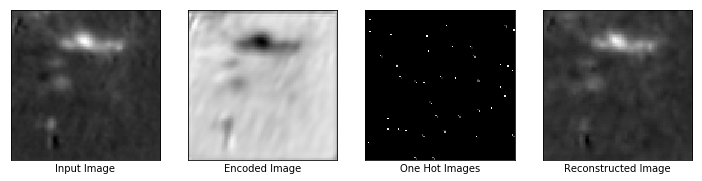

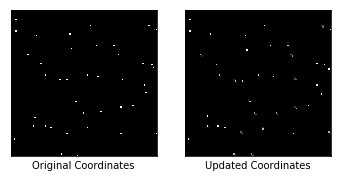

Epochs: 300, Loss: 0.0008374517201445997
Similarity scores: [ 3.4380257   5.1451073   5.5759068   4.1020937   3.3018646  -4.243941
 -0.6014857   4.2485576   5.1883473   2.3577209   4.5162935  -1.0834728
  2.7431183   4.8697658   4.8326316   3.0815508   2.5998502   4.549045
  2.5747523   4.8198805   3.9424937   1.1943408   3.8812325   3.657094
  5.7996645   3.705535    5.6474447  -3.0558522   4.9173875   4.122302
 -1.1899743   4.9768786   2.141304   -0.23157008  3.5688348   5.3253455
  3.8036654   1.2912583   3.6481376   4.372128  ]
Updated Coordinates: [[[0.45939988 0.99685085]]]
Gradient min:-0.0009860043646767735, max:0.00035381477209739387



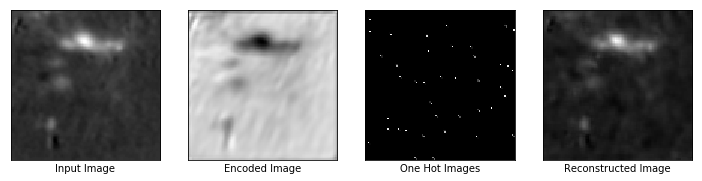

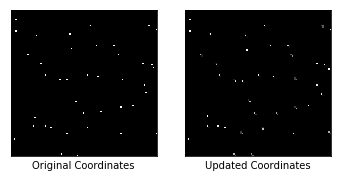

Epochs: 310, Loss: 0.0007245180895552039
Similarity scores: [ 3.3186607   4.917016    5.623743    4.0185404   3.2138264  -4.6183043
 -0.82536405  4.4545927   4.838088    2.3327856   4.6752467  -1.3275466
  2.5146513   4.3080797   4.6696815   3.0247943   2.3061643   4.599551
  2.2509282   4.591736    3.846544    0.98255455  3.9231424   3.4590607
  5.393334    3.5256262   5.595309   -3.4670975   4.192298    3.9977212
 -1.3669609   4.566546    1.8056073  -0.3415808   3.30608     5.636974
  3.803875    0.7244199   3.3194454   3.896496  ]
Updated Coordinates: [[[0.45946255 0.99682033]]]
Gradient min:-0.000172376079717651, max:0.00041678291745483875



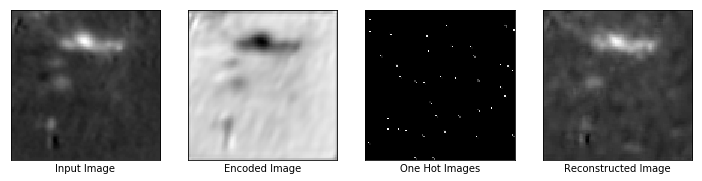

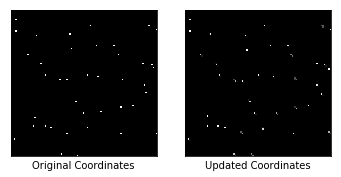

Epochs: 320, Loss: 0.0018118780571967363
Similarity scores: [ 3.3681982   5.3247333   5.59812     4.029345    3.2961545  -4.5498724
 -0.4289583   4.359579    5.421603    2.598171    4.362628   -1.2218819
  2.8087244   5.060465    4.9587784   3.0613449   2.7866323   4.6367693
  2.663206    4.9166756   4.045553    1.0666394   4.1185265   4.1050673
  6.044245    3.77006     5.753226   -3.521443    5.062187    4.362557
 -1.1783247   5.1738167   2.0928822  -0.29710856  3.7333982   5.6375003
  3.8138247   1.4065851   3.772226    5.1874156 ]
Updated Coordinates: [[[0.45973387 0.9969172 ]]]
Gradient min:-0.0034958366304636, max:0.0007074097520671785



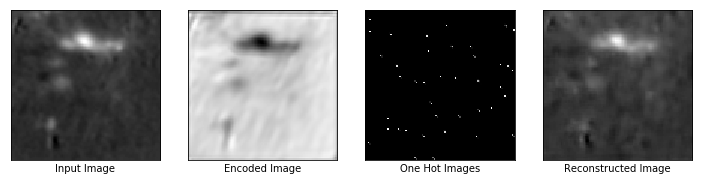

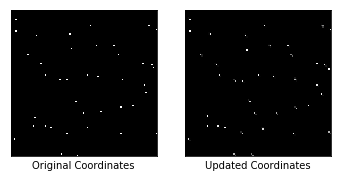

Epochs: 330, Loss: 0.00266588618978858
Similarity scores: [ 3.0406837   4.357916    4.543507    3.4036534   2.871649   -3.0534317
 -0.27065772  3.6195784   4.40815     2.1193326   3.6414096  -0.47122887
  2.329909    4.125826    4.1447806   2.526978    2.2906663   3.8055296
  2.2756705   3.9551718   3.4810805   1.1377679   3.4922278   3.4171214
  4.793293    2.9957094   4.375105   -2.3541794   4.1270094   3.3665102
 -0.5127966   4.2346215   1.8332458   0.04901926  3.1791518   4.4597783
  3.2355306   1.4891058   3.1499467   3.942811  ]
Updated Coordinates: [[[0.46002537 0.9971217 ]]]
Gradient min:-0.0005776789039373398, max:0.0036989054642617702



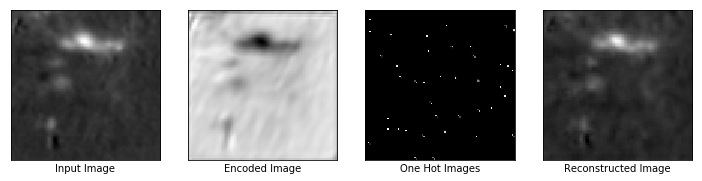

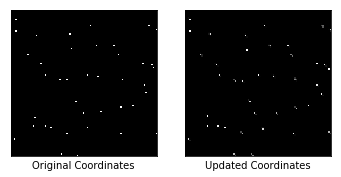

Epochs: 340, Loss: 0.001018168986774981
Similarity scores: [ 3.1325436   4.486399    4.9303684   3.6587484   3.0124652  -3.3984523
 -0.13319272  3.9428382   4.4493823   2.4817634   4.192796   -0.5541534
  2.4357576   4.1161504   4.3242016   2.9817083   2.3399346   4.078414
  2.3132472   4.06303     3.5774853   1.2017324   3.6711156   3.5179074
  4.854527    3.2988722   4.9685435  -2.6459966   4.0756326   3.6923912
 -0.942359    4.288727    1.8336883   0.26753607  3.2265778   4.89522
  3.5179183   1.3737407   3.2035763   3.8207169 ]
Updated Coordinates: [[[0.46000487 0.9970922 ]]]
Gradient min:-0.00039153185207396746, max:0.0021263929083943367



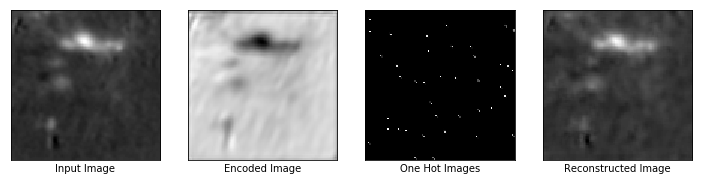

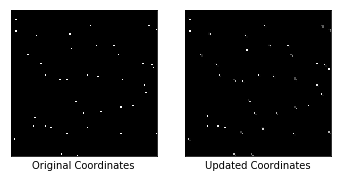

Epochs: 350, Loss: 0.0006220911745913327
Similarity scores: [ 2.9310484   4.3990803   5.2630444   3.6591184   2.9106758  -3.8859048
 -0.31228152  4.0688744   4.365644    2.4551344   4.235383   -0.7788017
  2.425378    4.0010314   4.206435    3.0001833   2.151282    4.145545
  2.2401414   4.147247    3.5077655   1.13647     3.5780141   3.2215238
  4.8474445   3.4694085   5.296629   -3.0323043   3.8509874   3.8904297
 -1.1970646   4.1644087   1.8450832  -0.01978964  3.0455315   5.063415
  3.4854364   1.6480772   3.0711038   3.6125426 ]
Updated Coordinates: [[[0.46003133 0.9970852 ]]]
Gradient min:-0.0003829608322121203, max:5.606030754279345e-06



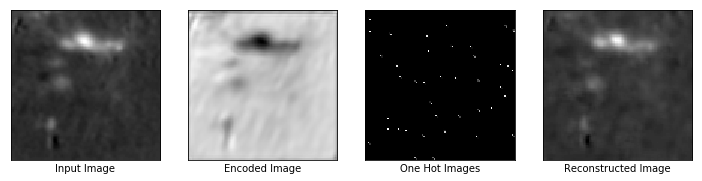

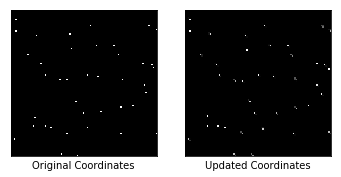

Epochs: 360, Loss: 0.0008135266252793372
Similarity scores: [ 3.081935    4.4698305   5.6481614   3.7515867   2.9856842  -3.9469867
 -0.19367649  4.1928906   4.5011973   2.6048837   4.4813747  -0.64942104
  2.6089094   4.191537    4.2767825   3.2302501   2.2803876   4.329274
  2.4431098   4.3795557   3.646735    1.2546033   3.9476786   3.2099488
  4.98291     3.723267    5.735157   -3.1029966   4.0752854   4.264036
 -1.0866601   4.2875376   1.9033113   0.21750292  3.1773589   5.307751
  3.5764928   2.1831377   3.2093415   3.8517504 ]
Updated Coordinates: [[[0.46021283 0.99726254]]]
Gradient min:-0.00037763381260447204, max:0.0006243099924176931



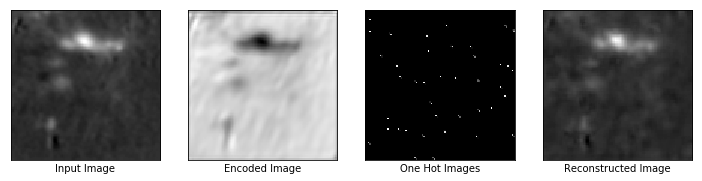

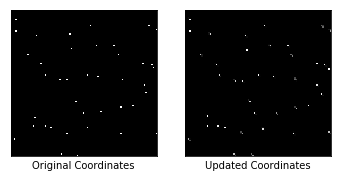

Epochs: 370, Loss: 0.0010652887867763638
Similarity scores: [ 2.9249706   4.7492146   5.2858095   3.75102     3.0220563  -4.068365
 -0.09458772  4.040714    4.807569    2.5878675   3.9630222  -0.8925455
  2.6562116   4.430836    4.4681263   2.9562857   2.5258648   4.312434
  2.4899907   4.3274264   3.7321205   1.1824858   3.8108544   3.8047218
  5.309058    3.5901055   5.5365725  -3.1425986   4.266299    4.0353947
 -1.06744     4.558623    2.2348874  -0.17891388  3.34272     5.2234926
  3.5327454   1.5302476   3.4367504   4.651136  ]
Updated Coordinates: [[[0.46024147 0.9973726 ]]]
Gradient min:-0.0025820257142186165, max:0.00048747489927336574



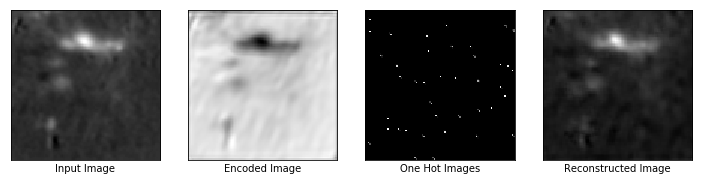

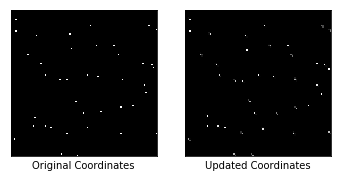

Epochs: 380, Loss: 0.0012249054852873087
Similarity scores: [ 3.3368454   4.3136      4.5705976   3.5348141   2.9745848  -4.068377
 -0.4785599   3.809254    4.197369    2.470868    4.325612   -0.7891464
  2.2334597   3.6872659   4.3002157   3.0626345   1.9055477   3.9504979
  2.1023555   3.5108607   3.4808688   1.0282013   4.1039085   3.6637356
  4.463995    2.9987557   4.2584424  -3.2830498   3.4003763   3.1157594
 -1.1758142   4.040839    1.5540922   0.32502884  3.1248507   4.709348
  3.5252404   0.9910315   2.9599464   3.7050326 ]
Updated Coordinates: [[[0.46042004 0.9974794 ]]]
Gradient min:-0.00018868542974814773, max:0.0015166159719228745



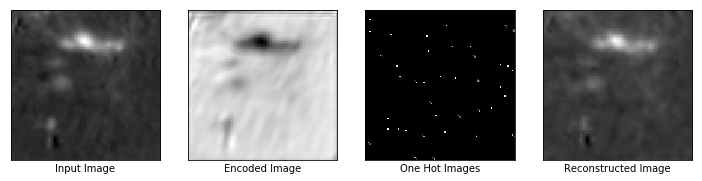

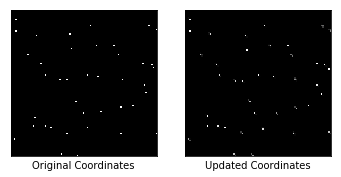

Epochs: 390, Loss: 0.0005915359361097217
Similarity scores: [ 3.2172933   4.5581126   4.938489    3.6888251   2.934413   -4.2947803
 -0.45076007  3.9219892   4.5246043   2.4479485   4.0631146  -0.991228
  2.4378884   3.9805322   4.380324    2.860065    2.1874516   4.129063
  2.3185072   3.8965657   3.5819774   1.0785086   3.9053917   3.711525
  5.0168195   3.1579444   4.7534227  -3.307257    3.8149195   3.4484172
 -1.2544571   4.347102    1.9850494  -0.08045158  3.2025414   5.0016265
  3.4613488   0.9996998   3.1969345   3.9809234 ]
Updated Coordinates: [[[0.46029055 0.9974622 ]]]
Gradient min:-0.00014256480790209025, max:0.00039474343066103756



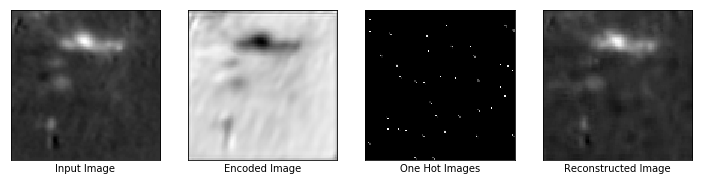

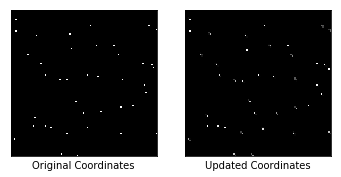

Epochs: 400, Loss: 0.0006575352745130658
Similarity scores: [ 2.8592973   4.7942405   5.038468    3.7691286   2.9916058  -4.181934
 -0.20807694  3.8852623   4.804092    2.5240417   4.135022   -0.95888823
  2.5721064   4.3420305   4.585953    2.9543262   2.386109    4.220695
  2.4479623   4.155067    3.6727104   1.0515859   3.8353398   3.7340775
  5.221273    3.320865    4.796469   -3.3395877   4.160649    3.5779464
 -1.4757745   4.6382875   2.1991706   0.0235137   3.3654878   5.0631356
  3.5241258   1.3604802   3.403427    3.923656  ]
Updated Coordinates: [[[0.4603502 0.9974031]]]
Gradient min:-2.959718221973162e-05, max:0.0003449204668868333



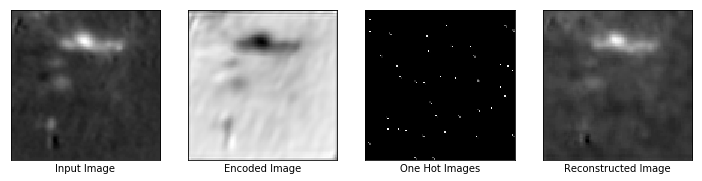

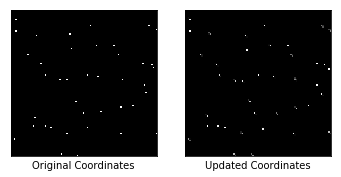

Epochs: 410, Loss: 0.001557231298647821
Similarity scores: [ 4.2283688   4.5008507   4.6249094   3.7572913   3.2852771  -3.6500025
 -0.37663582  4.08443     4.36349     2.849998    4.710965   -0.5345255
  2.3838587   3.7815058   4.622492    3.3686912   1.9868914   4.1541224
  2.279462    3.5810766   3.699897    1.068637    5.172835    3.9268339
  4.4541407   3.0977302   4.543308   -2.8459194   3.3898284   3.178897
 -1.1870781   4.2278214   2.1480017   0.8227402   3.3634043   4.792438
  3.8368618   1.1406225   3.1003182   4.040695  ]
Updated Coordinates: [[[0.460163  0.9972789]]]
Gradient min:-0.0001316841517109424, max:0.002967569511383772



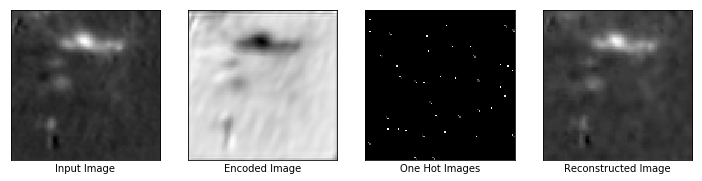

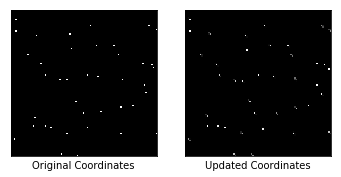

Epochs: 420, Loss: 0.0006592717836610973
Similarity scores: [ 3.3602424   4.387026    4.839213    3.6314864   2.9328501  -4.0064445
 -0.5188503   3.936673    4.3258123   2.6419103   4.368877   -0.86582917
  2.3736258   3.8318002   4.3192735   3.0607207   2.0011673   4.0650754
  2.257942    3.678461    3.5068915   1.0101539   4.332604    3.7248793
  4.599796    3.1817064   4.789529   -3.0226557   3.5766287   3.277296
 -1.2840606   4.1678214   2.1713643   0.12583546  3.1235373   4.910161
  3.5224428   1.0861579   3.0340147   4.068175  ]
Updated Coordinates: [[[0.46012875 0.99719995]]]
Gradient min:-0.00013373256660997868, max:0.0010506696999073029



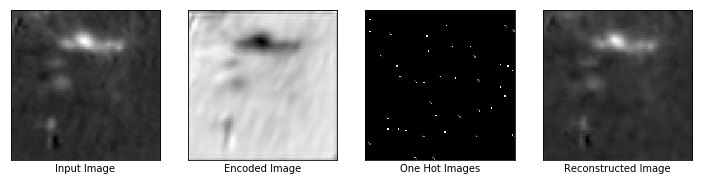

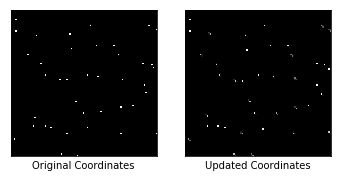

Epochs: 430, Loss: 0.0006380223203450441
Similarity scores: [ 3.2472844   4.398256    4.936451    3.6528313   2.9264755  -4.150016
 -0.5327997   3.956653    4.27923     2.6492405   4.3482304  -0.91751206
  2.3742714   3.727035    4.300068    3.0525184   1.9630324   4.094918
  2.2622476   3.6838152   3.5171404   1.0006247   4.249384    3.563414
  4.645855    3.1888463   4.81846    -3.1223304   3.4604516   3.3162732
 -1.3097533   4.156837    2.1929283   0.03850571  3.08818     4.9771953
  3.5205827   1.0605263   3.0280306   3.9890127 ]
Updated Coordinates: [[[0.4601394 0.9971563]]]
Gradient min:-0.00010348041541874409, max:0.0008513362845405936



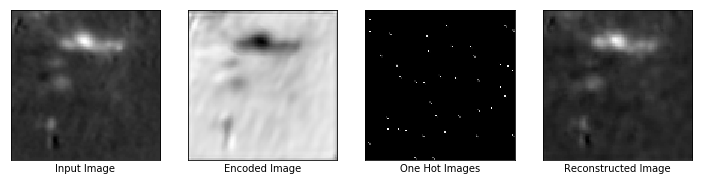

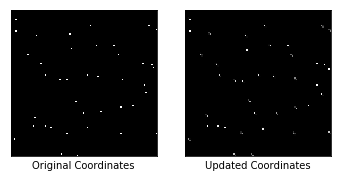

Epochs: 440, Loss: 0.001712750643491745
Similarity scores: [ 3.2768607   4.5310926   5.0121236   3.7681649   3.0225925  -4.098439
 -0.4106917   4.0088425   4.4458137   2.5940628   4.4773593  -0.873241
  2.4640973   3.9309623   4.445255    3.1183462   2.132459    4.20184
  2.3747995   3.6943583   3.6159472   1.137133    4.1805315   3.3841932
  4.7566004   3.2467594   4.796393   -3.1124315   3.545738    3.3921793
 -1.6438016   4.2861514   2.144218    0.26602975  3.1916902   4.898071
  3.6174803   1.6058127   3.1248848   3.7022185 ]
Updated Coordinates: [[[0.46008578 0.9971809 ]]]
Gradient min:-0.0004267780459485948, max:0.0023528996389359236



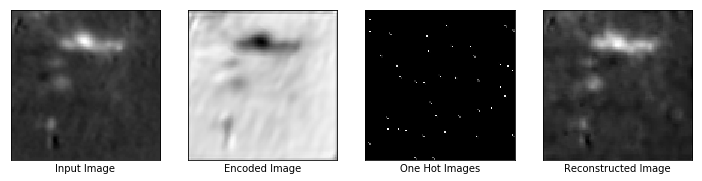

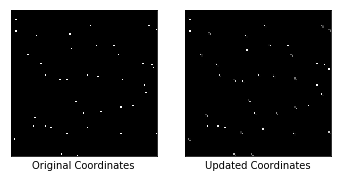

Epochs: 450, Loss: 0.0008059734245762229
Similarity scores: [ 3.4264412   4.8168173   4.9382057   3.7029653   2.9669657  -4.1975703
 -0.40360227  3.735746    4.9509025   2.2854419   3.9120533  -0.9540546
  2.5642543   4.504945    4.5497866   2.7756646   2.5090442   4.2440968
  2.5359833   4.0579963   3.6682816   0.9901295   4.101229    3.805454
  5.3610506   3.1158864   4.578173   -3.1034875   4.284698    3.3328457
 -1.1622412   4.714881    2.6185787  -0.1118146   3.4377546   4.988211
  3.444054    1.1826768   3.4921694   4.4859753 ]
Updated Coordinates: [[[0.46003038 0.9970287 ]]]
Gradient min:-3.2215670216828585e-05, max:0.0005474166246131063



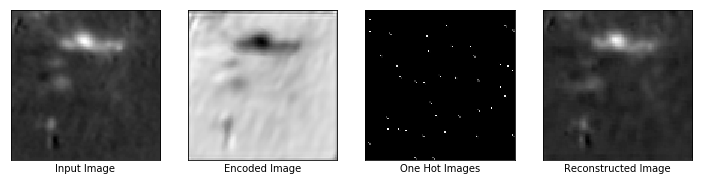

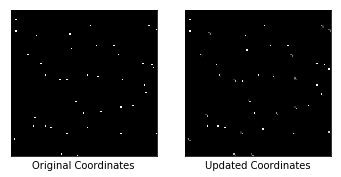

Epochs: 460, Loss: 0.0021797725930809975
Similarity scores: [ 3.0359445   3.981036    4.901201    3.3285608   2.6290164  -3.2153983
 -0.30786514  3.689696    3.962917    2.3558435   4.020703   -0.40703067
  2.3716128   3.5303795   3.801398    2.805296    2.0561304   3.8818786
  2.2405717   3.7159631   3.2301009   1.0971997   3.8367078   3.1279387
  4.3104486   3.196722    4.8857713  -2.6634765   3.3682172   3.4645734
 -0.5380218   3.7600517   2.216741    0.12376226  2.8379707   4.703342
  3.1780324   1.6412337   2.895459    3.6876154 ]
Updated Coordinates: [[[0.46023613 0.9972707 ]]]
Gradient min:-0.0007031171699054539, max:0.0029638451524078846



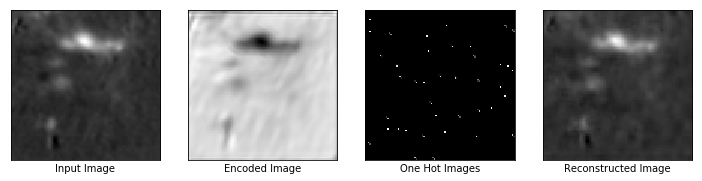

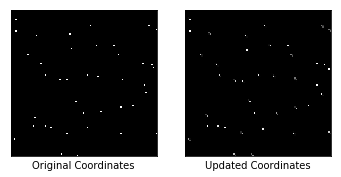

Epochs: 470, Loss: 0.0007237051031552255
Similarity scores: [ 3.3438656   4.2558174   5.0523176   3.5597675   2.7854898  -3.9428117
 -0.3834952   3.8465095   4.2325144   2.4663792   4.16014    -0.67921454
  2.466386    3.7907157   4.10378     2.925665    2.0157578   4.102386
  2.3643827   3.802482    3.4331572   1.1135427   4.1284146   3.5221279
  4.5730624   3.283478    4.9829006  -3.0284448   3.5450766   3.5104885
 -0.9124683   4.0071373   2.4802237   0.12111919  2.9961514   4.944887
  3.3579476   1.4649876   3.0377727   4.0000434 ]
Updated Coordinates: [[[0.46025375 0.9973048 ]]]
Gradient min:-0.00029304364579729736, max:0.0016317181289196014



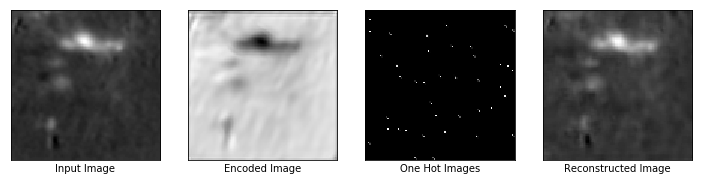

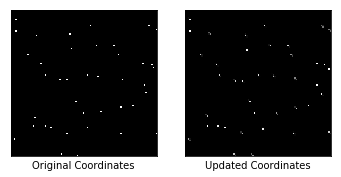

Epochs: 480, Loss: 0.0005964377196505666
Similarity scores: [ 3.166893    4.169591    5.0302563   3.439297    2.698132   -4.030503
 -0.39750215  3.6939828   4.2502484   2.4212043   3.8516188  -0.8201895
  2.4183936   3.815117    3.9771094   2.766508    1.9390411   4.02191
  2.357996    3.8003147   3.348979    1.0625128   3.9513001   3.442094
  4.6357856   3.2379377   4.962193   -3.00085     3.581013    3.435144
 -0.84698534  3.9956565   2.6335125  -0.1823561   2.9381714   4.951384
  3.201277    1.3724977   3.0167286   3.878669  ]
Updated Coordinates: [[[0.46027458 0.99735135]]]
Gradient min:-0.0003817911201622337, max:0.00048328033881261945



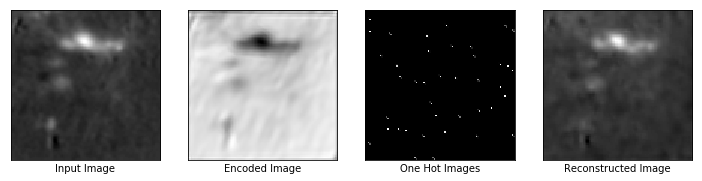

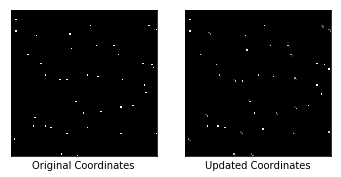

Epochs: 490, Loss: 0.001084186602383852
Similarity scores: [ 4.189782    4.5318737   4.55999     3.7441063   3.1573792  -4.483098
 -0.60250247  3.9089782   4.42529     2.681638    4.3414993  -0.6463539
  2.447686    3.8369606   4.5604787   3.0971892   1.9053495   4.1509457
  2.336802    3.424       3.6500492   1.0939912   4.999753    4.013582
  4.5521913   3.0474064   4.177105   -3.2665539   3.2878947   2.866486
 -1.2236832   4.241037    2.4283698   0.7676742   3.3333902   4.717219
  3.69583     0.5264545   3.1160421   4.009245  ]
Updated Coordinates: [[[0.46012446 0.99717087]]]
Gradient min:-0.000746345438528806, max:0.0008657333091832697



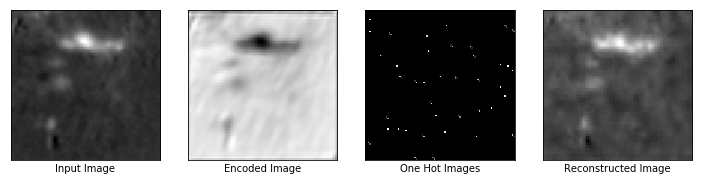

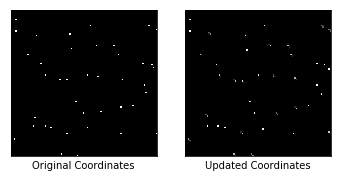

Epochs: 500, Loss: 0.0009213306475430727
Similarity scores: [ 3.987551    4.551627    5.133188    3.881176    3.2690747  -3.637076
 -0.40429235  4.2542624   4.5025506   2.7868304   4.6661725  -0.20975716
  2.7001898   3.9478781   4.5517793   3.404331    2.0728214   4.3783903
  2.611173    3.7945971   3.7408614   1.4245408   5.0202503   3.6395679
  4.65549     3.5200207   4.8969502  -2.7511435   3.5029106   3.5079348
 -0.7031584   4.3078017   2.2841344   0.98383117  3.3837323   5.067004
  3.8671296   1.5392132   3.2267332   3.8158813 ]
Updated Coordinates: [[[0.46010303 0.99712867]]]
Gradient min:-0.0007233067881315947, max:0.0005686236545443535


In [14]:
from utils_vis import plot_comparison

BATCH_SIZE = 8
MAX_EPOCHS = 500
batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)

#list to be append to output 
loss_list = []
input_imgs = []
coords_list = []
encoded_imgs = []
reconstructed_imgs = []
one_hot_imgs = []
captions_01 = ['Input Image', 'Encoded Image', 'One Hot Images','Reconstructed Image']
captions_02 = ['Original Coordinates', 'Updated Coordinates']

epochs = 1
while epochs <= MAX_EPOCHS:
    #reset coords for each epochs
#     coords,_, ori_one_hot_imgs = create_dat_samples(n_neurons)
#     coords = tf.reshape(coords, [n_neurons, 1,1,2])
    for steps, batched_imgs in enumerate(batch_imgs):
        loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad_model  = train_fn(batched_imgs, coords, img_size, BATCH_SIZE)
    loss_list.append(loss)
    if epochs%10==0:
        img_row01 = [batched_imgs[0], encoder_output[0], stack4plot(one_hot_imgs), reconstruction[0]]
        img_row02 = [stack4plot(ori_one_hot_imgs), stack4plot(one_hot_imgs)]
        plot_comparison(img_row01, captions_01, n_col=len(img_row01), figsize = (10, 10))
        plot_comparison(img_row02, captions_02, n_col=len(img_row02))
        print("Epochs: {}, Loss: {}".format(epochs, loss.numpy()))
        print("Similarity scores: {}".format(similarity_score[0]))
        print("Updated Coordinates: {}".format(updated_coords[0]))
        print("Gradient min:{}, max:{}".format(np.min(grad_model[0]), np.max(grad_model[0])))
    epochs+=1